In [1]:
from autogluon.tabular import TabularPredictor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import polars as pl 
import gc

/home/jovyan/share/data/analyses/benjamin/Single_cell_supervised/autogluon_analysis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
label_codes = {4: 'necroptosis inducer',
                        1: 'autophagy inducer',
                        2: 'ferroptosis inducer',
                        3: 'immunogenic cell death',
                        0: 'apoptosis',
                        5: 'pyroptosis inducer'}

# Load predictors

In [3]:
predictor_agg_DINO = TabularPredictor.load("/home/jovyan/share/data/analyses/benjamin/Single_cell_supervised/Autogluon_celldeath_DINO_aggregated")
predictor_agg_DP = TabularPredictor.load("/home/jovyan/share/data/analyses/benjamin/Single_cell_supervised/Autogluon_celldeath_DP_aggregated")
predictor_agg_CP = TabularPredictor.load("/home/jovyan/share/data/analyses/benjamin/Single_cell_supervised/Autogluon_celldeath_CP_aggregated")
predictor_DINO = TabularPredictor.load("/home/jovyan/share/data/analyses/benjamin/Single_cell_supervised/Autogluon_celldeath_DINO")
predictor_DP = TabularPredictor.load("/home/jovyan/share/data/analyses/benjamin/Single_cell_supervised/Autogluon_celldeath_DP_new")
predictor_CP = TabularPredictor.load("/home/jovyan/share/data/analyses/benjamin/Single_cell_supervised/Autogluon_celldeath_CP_new")


# Prep test data

## Load DP

In [7]:
test_set_DP = pl.read_csv("/home/jovyan/share/data/analyses/benjamin/DINO/CELLDEATH/datasets_paper/classification_splits/celldeath_moa_test_DINO.csv")
#dp_profiles = pl.read_parquet("/home/jovyan/share/data/analyses/benjamin/DINO/CELLDEATH/datasets_paper/sc_profiles_DINO_adjusted.parquet").drop("label")

In [6]:
def norm_test_feats(df, extractor, mode = "standard"):
    df = df.to_pandas()
    if mode == "standard":
        df_train_DP = pl.read_csv(f"/home/jovyan/share/data/analyses/benjamin/DINO/CELLDEATH/datasets_paper/classification_splits/celldeath_moa_train_{extractor}.csv").to_pandas()
        X_train_DP = df_train_DP.drop(['label'], axis=1).values
        scaler_DP = StandardScaler()
        X_train_DP_scaled = scaler_DP.fit_transform(X_train_DP)
        X_test_DP = df.drop("label", axis=1).values
        X_test_scaled_DP = scaler_DP.transform(X_test_DP)
        test_data_DP = pd.DataFrame(X_test_scaled_DP, columns=[f'feature_{i}' for i in range(X_test_DP.shape[1])])
        test_data_DP_join = pd.concat([test_data_DP, df["label"]], axis=1)
        return test_data_DP_join

    elif mode == "majority":
        if extractor == "DP":
            dp_profiles = pl.read_parquet("/home/jovyan/share/data/analyses/benjamin/DINO/CELLDEATH/datasets_paper/sc_profiles_DP_adjusted.parquet").drop("label")
            feature_columns_df1 = [col for col in dp_profiles.columns if "Feature" in col]
            feature_columns_df2 = [col for col in test_set_DP.columns if "Feature" in col]
        elif extractor == "DINO":
            dp_profiles = pl.read_parquet("/home/jovyan/share/data/analyses/benjamin/DINO/CELLDEATH/datasets_paper/sc_profiles_DINO.parquet").drop("label")
            feature_columns_df1 = [col for col in dp_profiles.columns if "Feature" in col]
            feature_columns_df2 = [col for col in test_set_DP.columns if "Feature" in col]
        elif extractor == "CP":
            dp_profiles = pl.read_parquet("/home/jovyan/share/data/analyses/benjamin/DINO/CELLDEATH/datasets_paper/sc_profiles_CP_full.parquet").drop("label")
            feature_columns_df1 = [col for col in test_set_CP.columns if "label" not in col]
            feature_columns_df2 = [col for col in cp_profiles.columns if col in feature_columns_df1 and "label" not in col]

        # Convert columns to `f32` type in both dataframes
        dp_profiles = dp_profiles.with_columns([pl.col(col).cast(pl.Float32) for col in feature_columns_df1])
        df = df.with_columns([pl.col(col).cast(pl.Float32) for col in feature_columns_df2])

        # Step 3: Perform the inner join on all matching "Feature" columns
        test_set_DP_join = dp_profiles.join(df, on=feature_columns_df1, how="inner")
        test_set_DP_join = test_set_DP_join.to_pandas()
        df_train_DP = pl.read_csv(f"/home/jovyan/share/data/analyses/benjamin/DINO/CELLDEATH/datasets_paper/classification_splits/celldeath_moa_train_{extractor}_adjusted.csv").to_pandas()
        X_train_DP = df_train_DP.drop(["label"], axis=1).values
        scaler_DP = StandardScaler()
        X_train_DP_scaled = scaler_DP.fit_transform(X_train_DP)
        X_test_DP = test_set_DP_join.drop(meta_feats_DP, axis=1).values
        X_test_scaled_DP = scaler_DP.transform(X_test_DP)
        test_data_DP = pd.DataFrame(X_test_scaled_DP, columns=[f'feature_{i}' for i in range(X_test_DP.shape[1])])
        test_data_DP_join = pd.concat([test_data_DP, test_set_DP_join[meta_feats_DP]], axis=1)

        return test_data_DP_join

In [9]:
test_data_DP = norm_test_feats(test_set_DP, "DINO")

In [10]:
test_set_DP_join = test_data_DP.to_pandas()

AttributeError: 'DataFrame' object has no attribute 'to_pandas'

In [11]:
meta_feats_DP = [feat for feat in test_data_DP.columns if "Feature" not in feat]

In [11]:
df_train_DP = pl.read_csv("/home/jovyan/share/data/analyses/benjamin/DINO/CELLDEATH/datasets_paper/classification_splits/celldeath_moa_train_DP_adjusted.csv").to_pandas()
X_train_DP = df_train_DP.drop(["label"], axis=1).values
scaler_DP = StandardScaler()
X_train_DP_scaled = scaler_DP.fit_transform(X_train_DP)
X_test_DP = test_set_DP_join.drop(meta_feats_DP, axis=1).values
X_test_scaled_DP = scaler_DP.transform(X_test_DP)
test_data_DP = pd.DataFrame(X_test_scaled_DP, columns=[f'feature_{i}' for i in range(X_test_DP.shape[1])])
test_data_DP_join = pd.concat([test_data_DP, test_set_DP_join[meta_feats_DP]], axis=1)

## Load DINO

In [13]:
test_set_DINO = pl.read_csv("/home/jovyan/share/data/analyses/benjamin/DINO/CELLDEATH/datasets_paper/classification_splits/celldeath_moa_test_DINO.csv")
test_data_DINO = norm_test_feats(test_set_DINO, "DINO")

In [5]:
test_set_DINO_agg = pl.read_csv("/home/jovyan/share/data/analyses/benjamin/DINO/CELLDEATH/datasets_paper/classification_splits/celldeath_moa_test_DINO_aggregated.csv")
test_data_DINO_agg = norm_test_feats(test_set_DINO_agg, "DINO")

NameError: name 'norm_test_feats' is not defined

In [16]:
meta_feats_DINO = [feat for feat in test_data_DINO.columns if "feature" not in feat]

## Load CP

In [49]:
test_set_CP = pl.read_csv("/home/jovyan/share/data/analyses/benjamin/DINO/CELLDEATH/datasets_paper/classification_splits/celldeath_moa_test_CP_aggregated.csv")
#.to_pandas()
cp_profiles = pl.read_parquet("/home/jovyan/share/data/analyses/benjamin/DINO/CELLDEATH/datasets_paper/sc_profiles_CP_full.parquet").drop("label")

In [6]:
feature_columns_df1 = [col for col in test_set_CP.columns if "label" not in col]
feature_columns_df2 = [col for col in cp_profiles.columns if col in feature_columns_df1 and "label" not in col]


In [7]:
# Convert columns to `f32` type in both dataframes
cp_profiles = cp_profiles.with_columns([pl.col(col).cast(pl.Float32) for col in feature_columns_df2])
test_set_CP = test_set_CP.with_columns([pl.col(col).cast(pl.Float32) for col in feature_columns_df1])

# Step 3: Perform the inner join on all matching "Feature" columns
test_set_CP_join = cp_profiles.join(test_set_CP, on=feature_columns_df1, how="inner")

In [8]:
test_set_CP_join = test_set_CP_join.to_pandas()
meta_feats_CP = [feat for feat in test_set_CP_join.columns if feat not in feature_columns_df1]

In [9]:
df_train_CP = pl.read_csv("/home/jovyan/share/data/analyses/benjamin/DINO/CELLDEATH/datasets_paper/classification_splits/celldeath_moa_train_CP.csv").to_pandas()
X_train_CP = df_train_CP.drop(['label'], axis=1).values
scaler_CP = StandardScaler()
X_train_CP_scaled = scaler_CP.fit_transform(X_train_CP)

In [10]:
X_test_CP = test_set_CP_join.drop(meta_feats_CP, axis=1).values
X_test_scaled_CP = scaler_CP.transform(X_test_CP)
test_data_CP = pd.DataFrame(X_test_scaled_CP, columns=[f'feature_{i}' for i in range(X_test_CP.shape[1])])
test_data_CP_join = pd.concat([test_data_CP, test_set_CP_join[meta_feats_CP]], axis=1)

## Leaderboards test set

In [20]:
predictor_agg.leaderboard(test_set_DINO_agg.to_pandas(), silent = True, extra_metrics = ["accuracy", "f1_macro", "f1_micro", "recall_macro", "precision_macro"])

2024-11-04 12:30:49,772	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
/home/jovyan/share/data/analyses/benjamin/Single_cell_supervised/autogluon_analysis/lib/python3.11/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


,model,score_test,accuracy,f1_macro,f1_micro,recall_macro,precision_macro,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetFastAI_BAG_L1_FULL,0.610063,0.610063,0.607961,0.610063,0.611696,0.607290,NaN,accuracy,2.894126,NaN,28.872790,2.894126,NaN,28.872790,1,True,95
1,NeuralNetTorch_r86_BAG_L1_FULL,0.606469,0.606469,0.602285,0.606469,0.606250,0.600859,NaN,accuracy,0.069067,NaN,97.763907,0.069067,NaN,97.763907,1,True,124
2,NeuralNetTorch_r41_BAG_L2_FULL,0.606469,0.606469,0.604122,0.606469,0.602866,0.605850,NaN,accuracy,9.907637,NaN,10087.663313,0.277074,NaN,32.145478,2,True,185
3,WeightedEnsemble_L2_FULL,0.605571,0.605571,0.600511,0.605571,0.602542,0.600423,NaN,accuracy,3.678378,NaN,3736.857731,0.007593,NaN,0.757419,2,True,139
4,LightGBM_BAG_L2_FULL,0.604672,0.604672,0.597939,0.604672,0.598537,0.598911,NaN,accuracy,9.730874,NaN,10104.934780,0.100311,NaN,49.416945,2,True,142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,CatBoost_r9_BAG_L1,NaN,NaN,NaN,NaN,NaN,NaN,0.754668,accuracy,NaN,0.248180,4716.227337,NaN,0.248180,4716.227337,1,False,16
184,NeuralNetFastAI_r156_BAG_L1,NaN,NaN,NaN,NaN,NaN,NaN,0.731702,accuracy,NaN,0.240259,12.839556,NaN,0.240259,12.839556,1,False,41
185,NeuralNetFastAI_r102_BAG_L1,NaN,NaN,NaN,NaN,NaN,NaN,0.719468,accuracy,NaN,0.120865,5.961651,NaN,0.120865,5.961651,1,False,22
186,NeuralNetFastAI_r143_BAG_L1,NaN,NaN,NaN,NaN,NaN,NaN,0.591973,accuracy,NaN,0.124694,8.281300,NaN,0.124694,8.281300,1,False,39


In [19]:
predictor.leaderboard(test_set_DP.to_pandas(), silent = True, extra_metrics = ["accuracy", "f1_macro", "f1_micro", "recall_macro", "precision_macro"])

2024-11-02 17:49:32,400	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
/home/jovyan/share/data/analyses/benjamin/Single_cell_supervised/autogluon_analysis/lib/python3.11/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/home/jovyan/share/data/analyses/benjamin/Single_cell_supervised/autogluon_analysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

,model,score_test,accuracy,f1_macro,f1_micro,recall_macro,precision_macro,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetTorch_r30_BAG_L2_FULL,0.502934,0.502934,0.500609,0.502934,0.503197,0.504856,NaN,accuracy,138.622158,NaN,11988.003190,1.683566,NaN,191.731297,2,True,79
1,NeuralNetTorch_r22_BAG_L2_FULL,0.491198,0.491198,0.487154,0.491198,0.494739,0.487141,NaN,accuracy,138.461751,NaN,11959.607029,1.523159,NaN,163.335136,2,True,70
2,NeuralNetTorch_r79_BAG_L2_FULL,0.487973,0.487973,0.485142,0.487973,0.486295,0.485007,NaN,accuracy,138.519059,NaN,11986.766851,1.580467,NaN,190.494958,2,True,65
3,LightGBMXT_BAG_L2_FULL,0.487788,0.487788,0.484272,0.487788,0.485720,0.485922,NaN,accuracy,137.339419,NaN,11863.860870,0.400827,NaN,67.588977,2,True,54
4,RandomForestEntr_BAG_L2_FULL,0.487074,0.487074,0.484567,0.487074,0.486348,0.485555,NaN,accuracy,140.956914,NaN,12267.817263,4.018322,45.517449,471.545370,2,True,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,LightGBMXT_BAG_L1,NaN,NaN,NaN,NaN,NaN,NaN,0.554386,accuracy,NaN,1877.548180,13801.782067,NaN,1877.548180,13801.782067,1,False,2
76,LightGBM_BAG_L1,NaN,NaN,NaN,NaN,NaN,NaN,0.543742,accuracy,NaN,1904.274359,15688.783179,NaN,1904.274359,15688.783179,1,False,3
77,CatBoost_BAG_L1,NaN,NaN,NaN,NaN,NaN,NaN,0.525070,accuracy,NaN,1.498806,6843.405565,NaN,1.498806,6843.405565,1,False,6
78,XGBoost_BAG_L1,NaN,NaN,NaN,NaN,NaN,NaN,0.505756,accuracy,NaN,44.395163,1242.619970,NaN,44.395163,1242.619970,1,False,9


In [48]:
[it for it in list(predictor.leaderboard()["model"]) if "FastAI" in it]

['NeuralNetFastAI_r145_BAG_L2',
 'NeuralNetFastAI_BAG_L2',
 'NeuralNetFastAI_r102_BAG_L2',
 'NeuralNetFastAI_r191_BAG_L2',
 'NeuralNetFastAI_BAG_L1',
 'NeuralNetFastAI_r191_BAG_L2_FULL',
 'NeuralNetFastAI_r145_BAG_L2_FULL',
 'NeuralNetFastAI_r102_BAG_L2_FULL',
 'NeuralNetFastAI_BAG_L2_FULL',
 'NeuralNetFastAI_BAG_L1_FULL']

In [ ]:
predictor_CP.leaderboard(test_set_CP.to_pandas(), silent = True, extra_metrics = ["accuracy", "f1_macro", "f1_micro", "recall_macro", "precision_macro"])

In [88]:
def evaluate_models_and_display_summary(test_data, label_column, predictor, top_n=10, model_name = None):
    """
    Evaluates all models on the test set and displays the top 5 models' metrics.

    Parameters:
    - test_data: The test DataFrame.
    - label_column: The name of the label column in test_data.
    - predictor: The trained AutoGluon TabularPredictor object.
    - top_n: Number of top models to display (default is 5).
    """
    y_test = test_data[label_column]
    X_test = test_data.drop(labels=[label_column], axis=1)
    
    # Getting the leaderboard
    
    # Evaluate all models and collect their predictions
    if model_name != None:
        model_names = model_name
    else:
        leaderboard = predictor.leaderboard(test_data, silent=True)
        model_names = leaderboard['model'][:top_n].to_list()
        
    performances = []
    all_reports = []
    #string_labels = [label_codes[label] for label in np.unique(y_test)]
    string_labels = np.unique(y_test)
    for model in model_names:
        y_pred = predictor.predict(X_test, model=model)
        report = classification_report(y_test, y_pred, output_dict=True)
        report_df = pd.DataFrame(report).transpose()
        report_df['model'] = model  # Add a column for the model
        all_reports.append(report_df)
        accuracy = accuracy_score(y_test, y_pred)
        performances.append((model, report, accuracy))

        print(f"Model: {model}, Accuracy: {accuracy:.4f}")
        display(pd.DataFrame(report).transpose())
        
        # Optional: Plot confusion matrix for each model
        cm = confusion_matrix(y_test, y_pred, labels=predictor.class_labels)
        cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Convert to percentage
        
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=string_labels)
        fig, ax = plt.subplots(figsize=(10,7), dpi = 300)
        disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='.2f')
        plt.title(f'{model}')
        plt.xlabel('Predicted label', fontweight = "bold")
        plt.ylabel('True label', fontweight = "bold")
        plt.savefig(f"/home/jovyan/share/data/analyses/benjamin/Single_cell_supervised/Autogluon_celldeath_DINO_aggregated/output/Celldeath_confusion_{model}_DINO.png")
        #plt.show()
    all_reports_df = pd.concat(all_reports, axis=0).reset_index().rename(columns={'index': 'metric'})
    output_path = f'/home/jovyan/share/data/analyses/benjamin/Single_cell_supervised/Autogluon_celldeath_DINO_aggregated/output/classification_report_celldeath_DINO.csv'
    all_reports_df.to_csv(output_path, index=False)
    return all_reports_df

Model: LightGBMXT_BAG_L2_FULL, Accuracy: 0.6020


,precision,recall,f1-score,support
0,0.591928,0.556962,0.573913,237.000000
1,0.629442,0.688889,0.657825,180.000000
2,0.693069,0.636364,0.663507,220.000000
3,0.564103,0.607735,0.585106,181.000000
4,0.567251,0.602484,0.584337,161.000000
5,0.536000,0.500000,0.517375,134.000000
accuracy,0.601977,0.601977,0.601977,0.601977
macro avg,0.596966,0.598739,0.597011,1113.000000
weighted avg,0.603159,0.601977,0.601714,1113.000000


Model: NeuralNetFastAI_BAG_L1_FULL, Accuracy: 0.6101


,precision,recall,f1-score,support
0,0.611650,0.531646,0.568849,237.000000
1,0.640000,0.711111,0.673684,180.000000
2,0.689655,0.636364,0.661939,220.000000
3,0.597826,0.607735,0.602740,181.000000
4,0.521277,0.608696,0.561605,161.000000
5,0.583333,0.574627,0.578947,134.000000
accuracy,0.610063,0.610063,0.610063,0.610063
macro avg,0.607290,0.611696,0.607961,1113.000000
weighted avg,0.612924,0.610063,0.609883,1113.000000


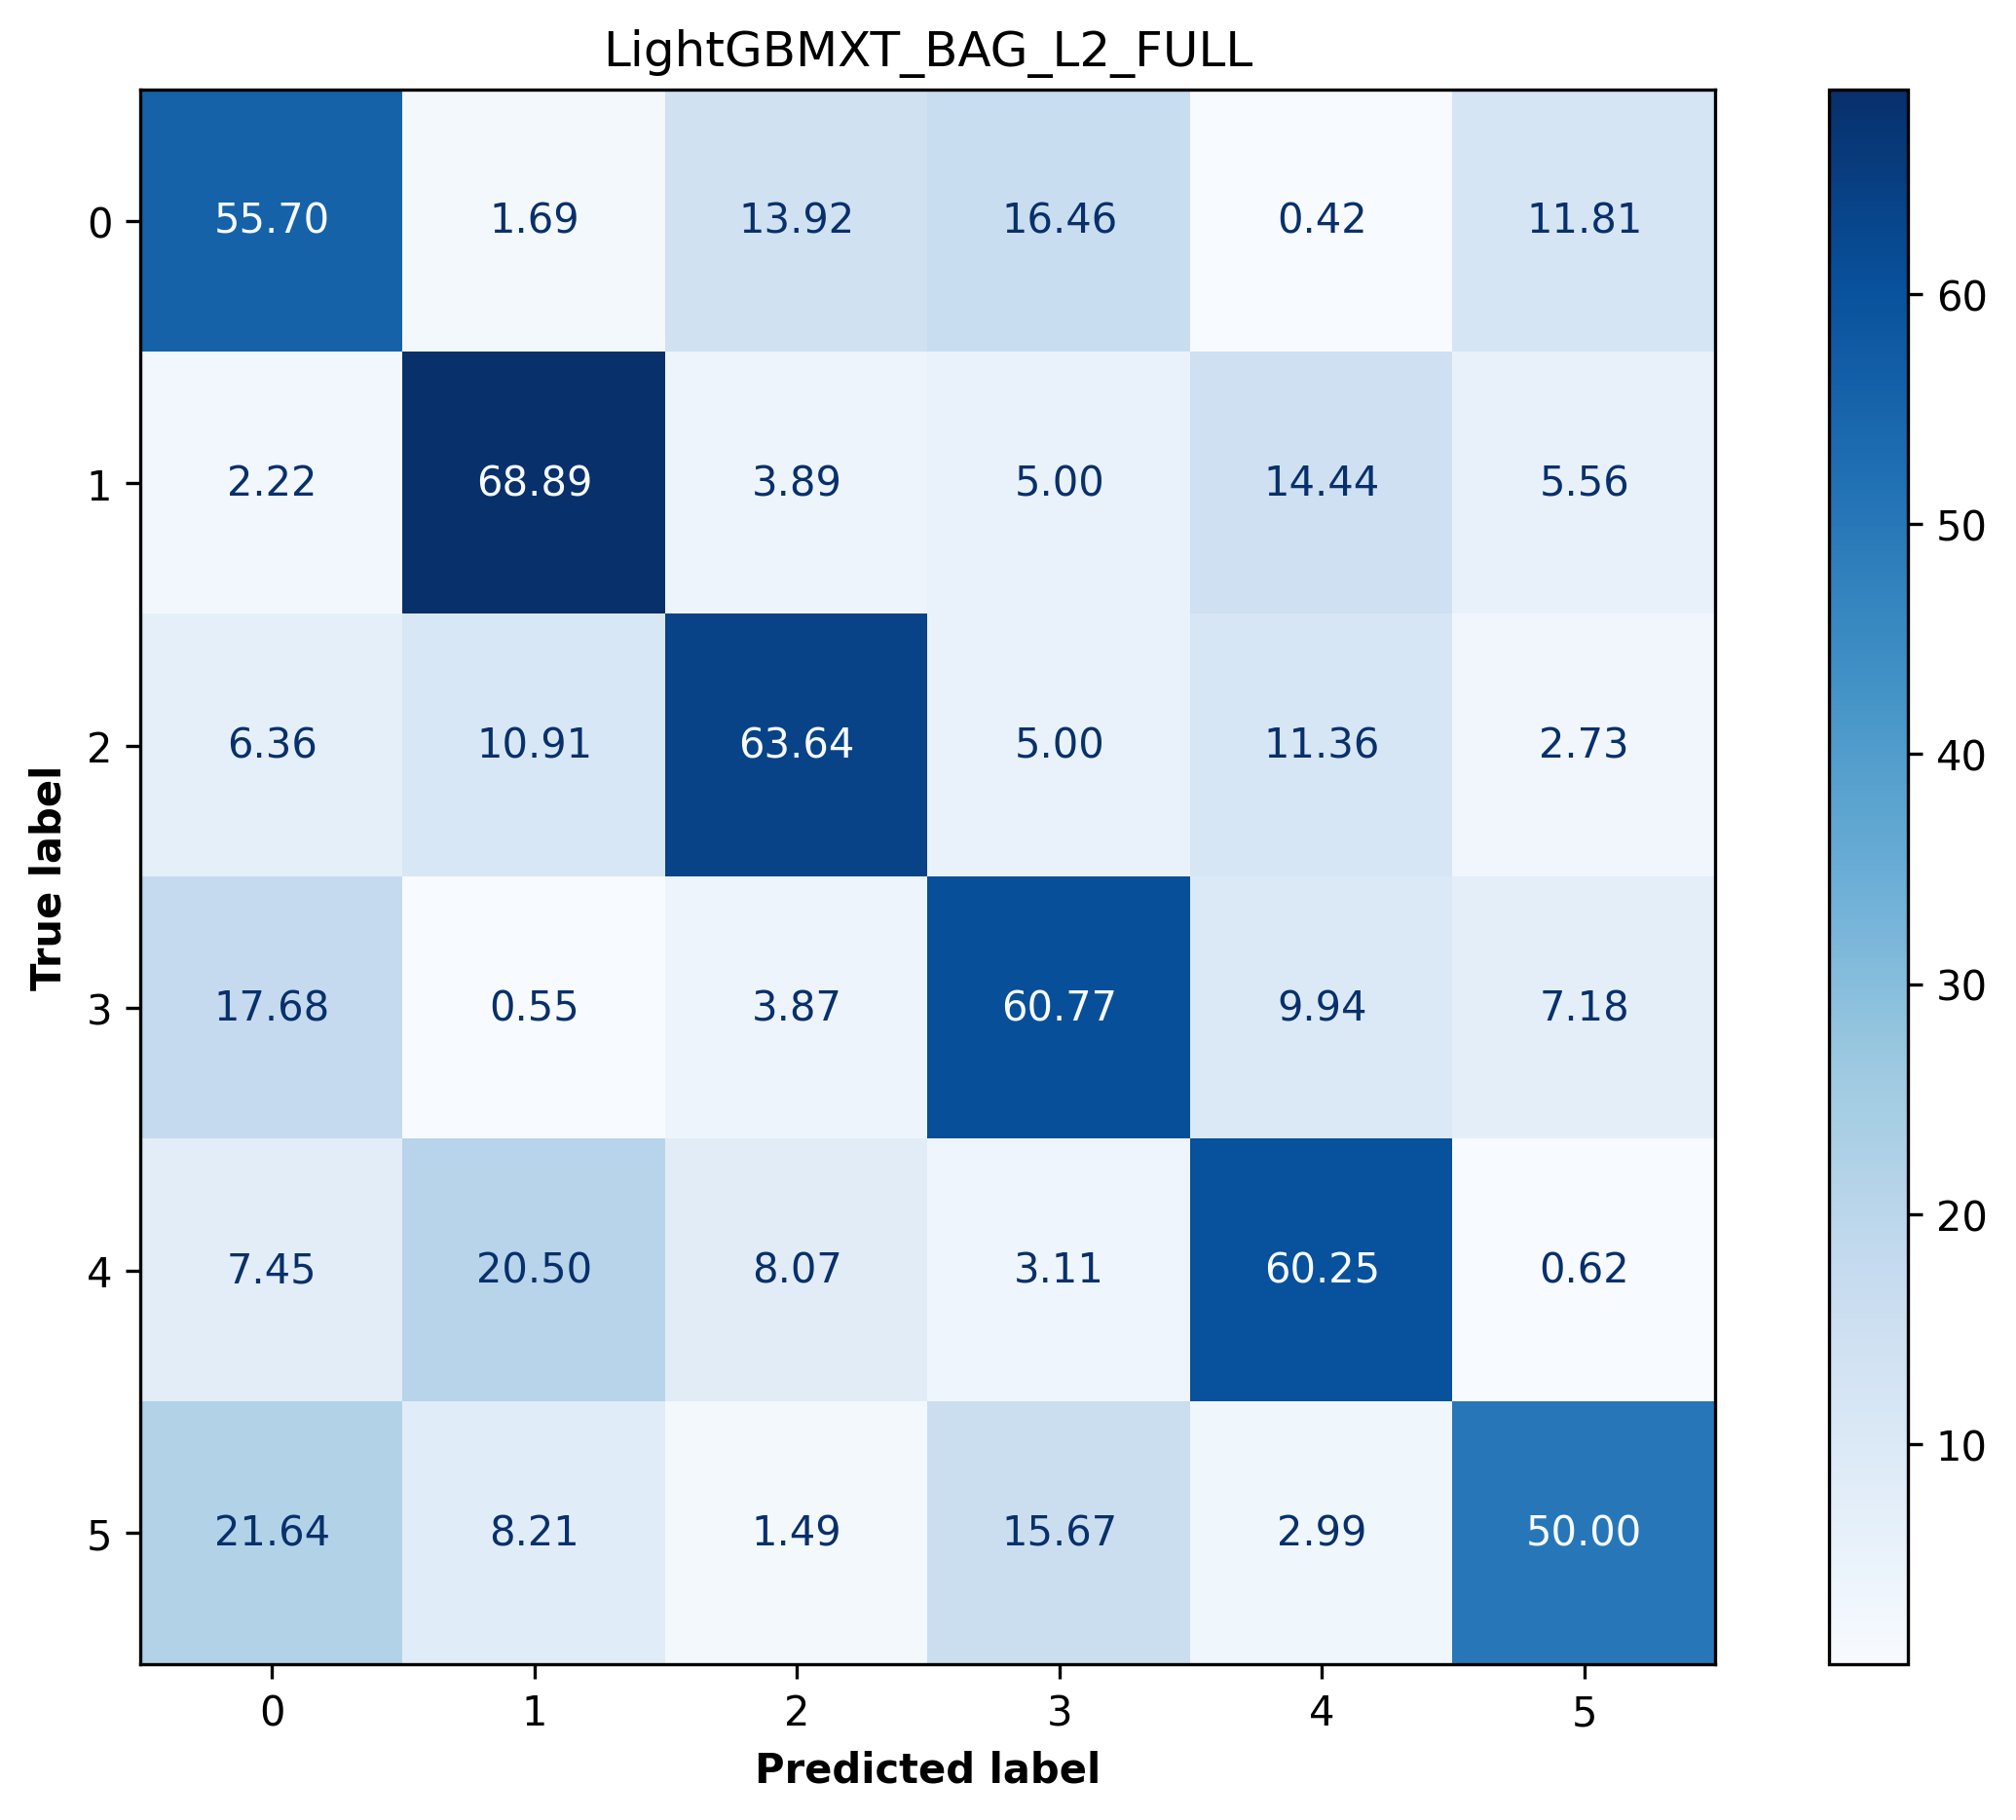

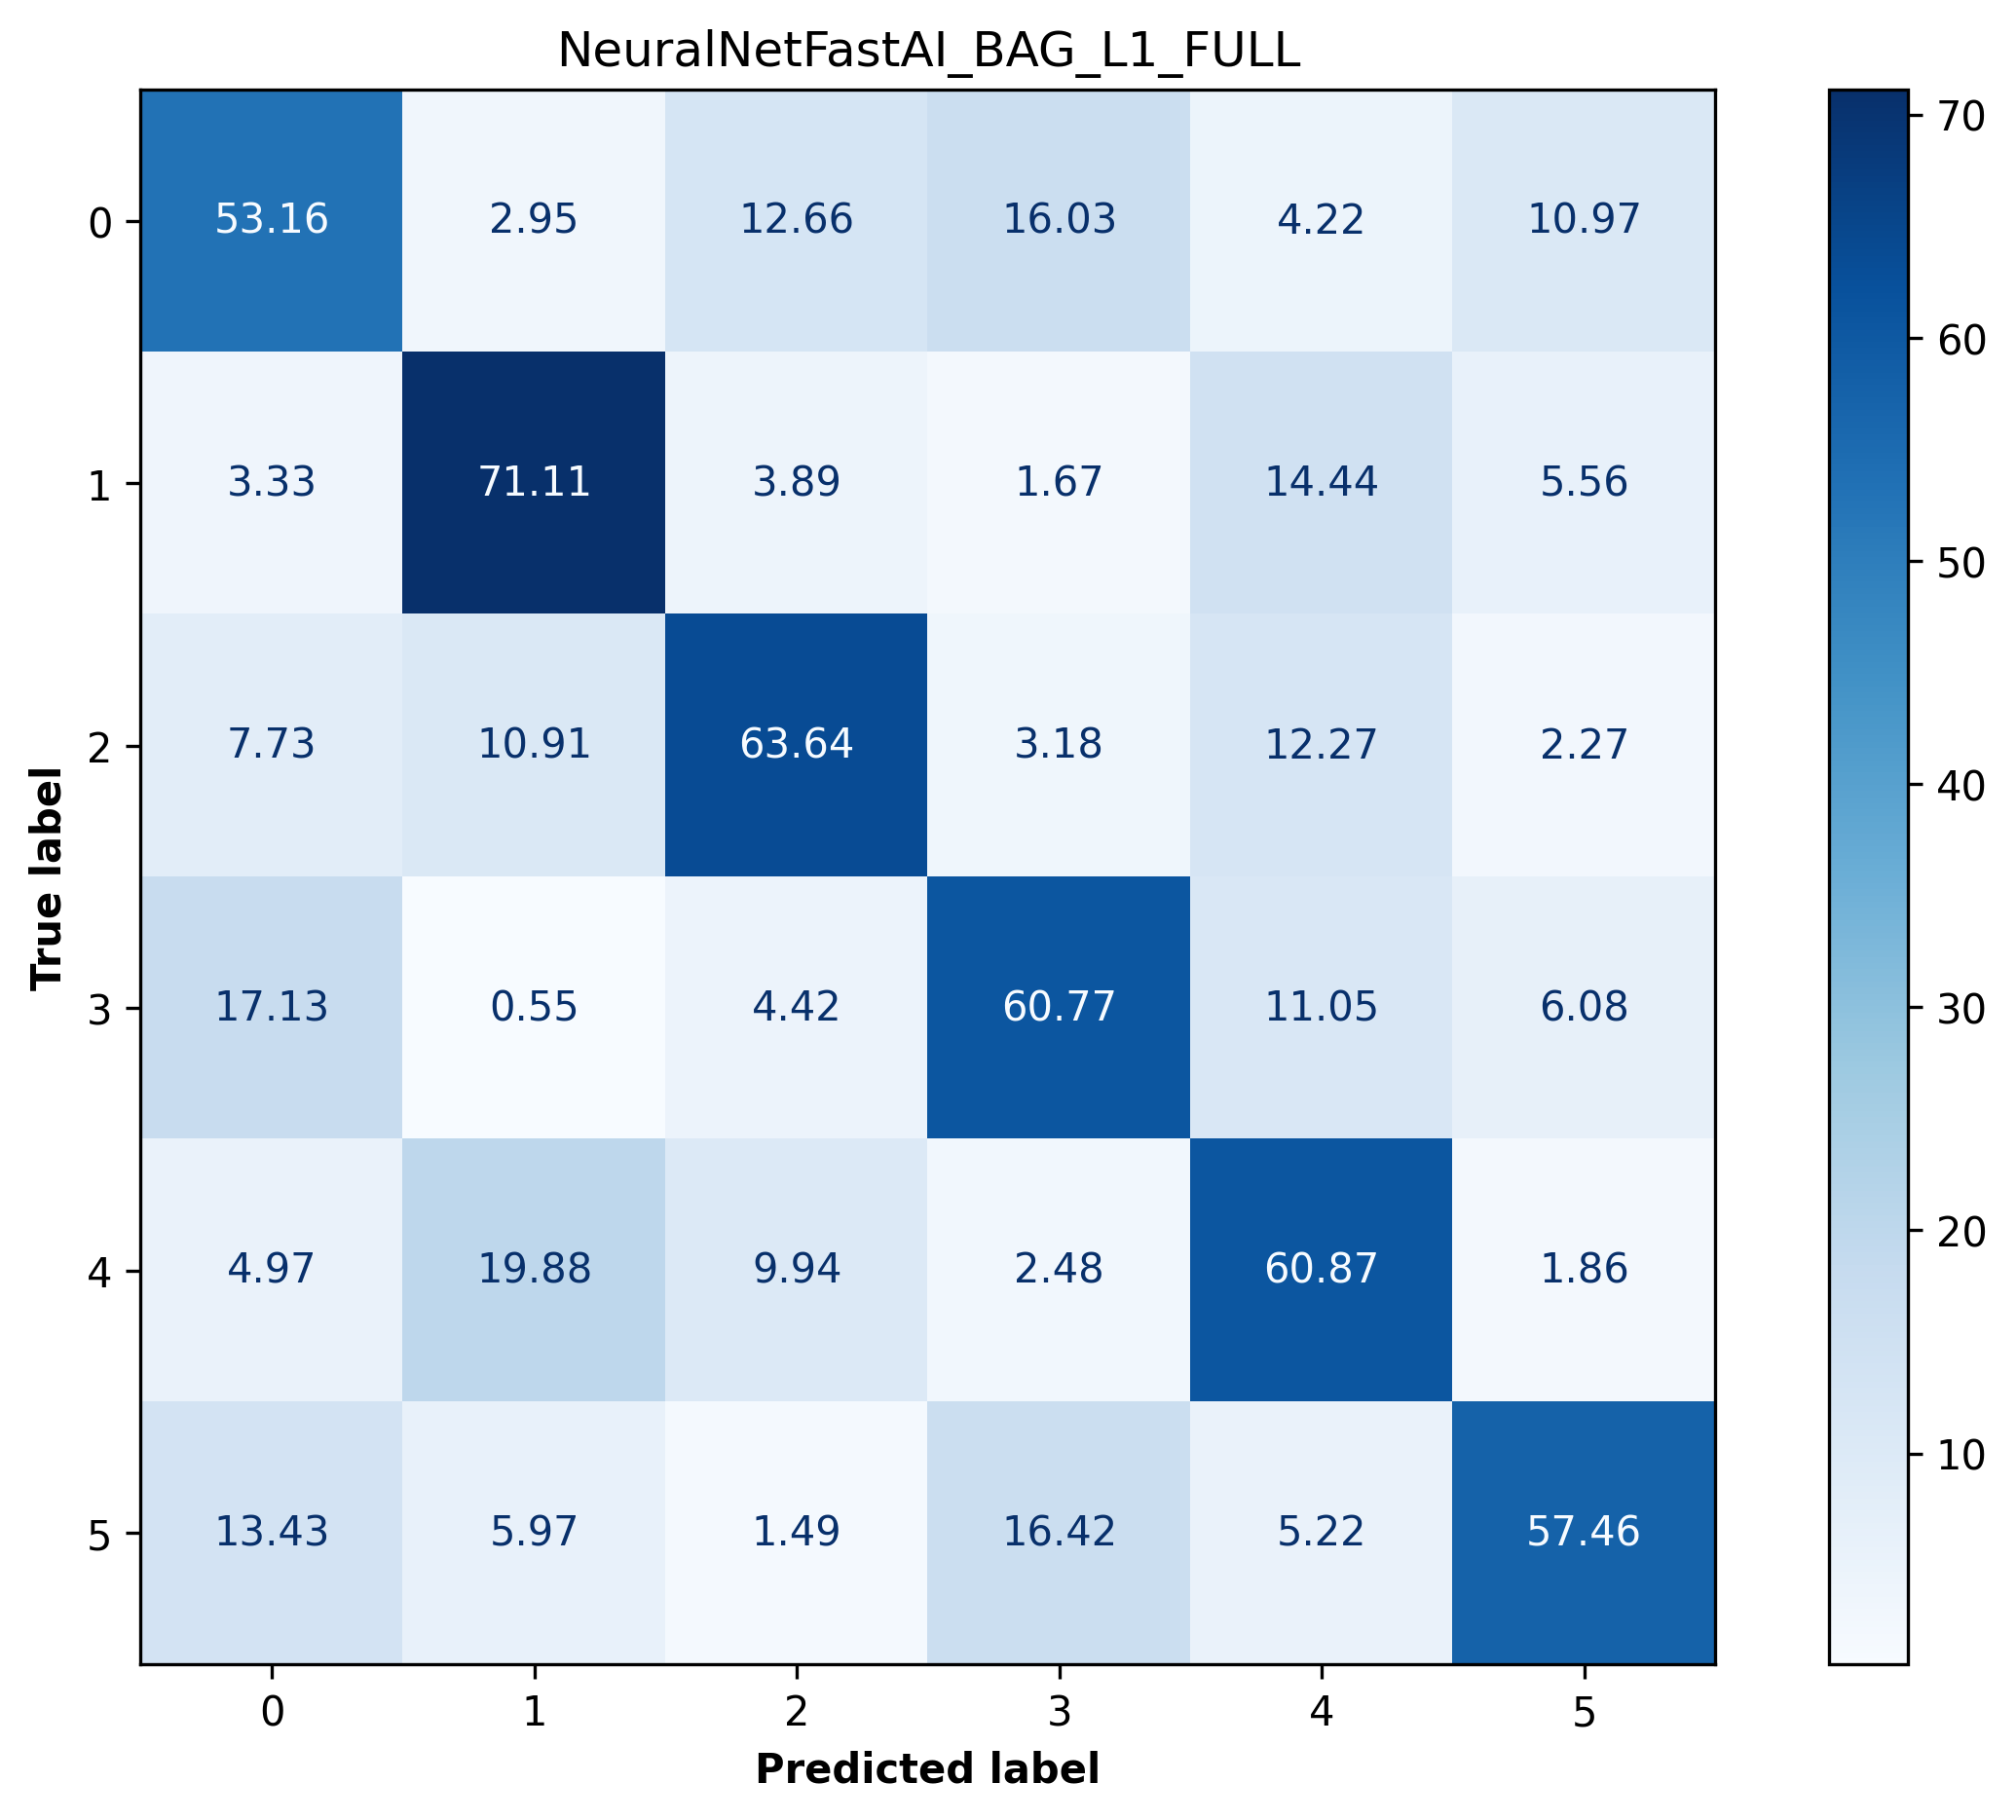

In [89]:
#autogl_res_DP = evaluate_models_and_display_summary(test_set_DINO.to_pandas(), "label", predictor= predictor, model_name = ["LightGBMXT_BAG_L2_FULL", "NeuralNetFastAI_BAG_L1_FULL"])
autogl_res_DP_agg = evaluate_models_and_display_summary(test_set_DP_agg.to_pandas(), "label", predictor= predictor_agg_DP, model_name = ["LightGBMXT_BAG_L2_FULL", "NeuralNetFastAI_BAG_L1_FULL"])
autogl_res_CP_agg = evaluate_models_and_display_summary(test_set_CP_agg.to_pandas(), "label", predictor= predictor_agg_CP, model_name = ["LightGBMXT_BAG_L2_FULL", "NeuralNetFastAI_BAG_L1_FULL"])
autogl_res_DINO_agg = evaluate_models_and_display_summary(test_set_DINO_agg.to_pandas(), "label", predictor= predictor_agg_DINO, model_name = ["LightGBMXT_BAG_L2_FULL", "NeuralNetFastAI_BAG_L1_FULL"])

autogl_res_DP = evaluate_models_and_display_summary(test_set_DP.to_pandas(), "label", predictor= predictor_DP, model_name = ["LightGBMXT_BAG_L2_FULL", "NeuralNetFastAI_BAG_L1_FULL"])
autogl_res_CP = evaluate_models_and_display_summary(test_data_CP.to_pandas(), "label", predictor= predictor_CP, model_name = ["LightGBMXT_BAG_L2_FULL", "NeuralNetFastAI_BAG_L1_FULL"])
autogl_res_DINO = evaluate_models_and_display_summary(test_set_DINO.to_pandas(), "label", predictor= predictor_DINO, model_name = ["LightGBMXT_BAG_L2_FULL", "NeuralNetFastAI_BAG_L1_FULL"])


# Majority voting

## Data prep

### DINO

In [ ]:
dino_profiles = pl.read_parquet("/home/jovyan/share/data/analyses/benjamin/DINO/CELLDEATH/datasets_paper/sc_profiles_filtered_DINO.parquet")
test_set_DINO_pl = pl.read_csv("/home/jovyan/share/data/analyses/benjamin/DINO/CELLDEATH/datasets_paper/classification_splits/celldeath_moa_test_DINO.csv")

In [60]:
feature_columns_df1 = [col for col in dino_profiles.columns if "Feature" in col]
feature_columns_df2 = [col for col in test_set_DINO_pl.columns if "Feature" in col]

# Convert columns to `f32` type in both dataframes
dino_profiles = dino_profiles.with_columns([pl.col(col).cast(pl.Float32) for col in feature_columns_df1])
test_set_DINO_pl = test_set_DINO_pl.with_columns([pl.col(col).cast(pl.Float32) for col in feature_columns_df2])

# Step 3: Perform the inner join on all matching "Feature" columns
joined_df_DINO = dino_profiles.join(test_set_DINO_pl, on=feature_columns_df1, how="inner")

In [ ]:
meta_dino = [feat for feat in joined_df.columns if "Feature" not in feat]

### DP

In [ ]:
dp_profiles = pl.read_parquet("/home/jovyan/share/data/analyses/benjamin/DINO/CELLDEATH/datasets_paper/sc_profiles_DP_adjusted.parquet")
test_set_DP_pl = pl.read_csv("/home/jovyan/share/data/analyses/benjamin/DINO/CELLDEATH/datasets_paper/classification_splits/celldeath_moa_test_DP_adjusted.csv")

In [ ]:
feature_columns_df1 = [col for col in dp_profiles.columns if "Feature" in col]
feature_columns_df2 = [col for col in test_set_DP_pl.columns if "Feature" in col]

# Convert columns to `f32` type in both dataframes
dp_profiles = dp_profiles.with_columns([pl.col(col).cast(pl.Float32) for col in feature_columns_df1])
test_set_DP_pl = test_set_DP_pl.with_columns([pl.col(col).cast(pl.Float32) for col in feature_columns_df2])

# Step 3: Perform the inner join on all matching "Feature" columns
joined_df_DP = dp_profiles.join(test_set_DP_pl, on=feature_columns_df1, how="inner")

In [ ]:
meta_DP = [feat for feat in joined_df_DP.columns if "Feature" not in feat]

### CP

In [ ]:
cp_profiles = pl.read_parquet("/home/jovyan/share/data/analyses/benjamin/DINO/CELLDEATH/datasets_paper/sc_profiles_CP.parquet")
test_set_CP_pl = pl.read_csv("/home/jovyan/share/data/analyses/benjamin/DINO/CELLDEATH/datasets_paper/classification_splits/celldeath_moa_test_CP.csv")

In [ ]:
feature_columns_df1 = [col for col in cp_profiles.columns if "Feature" in col]
feature_columns_df2 = [col for col in test_set_CP_pl.columns if "Feature" in col]

# Convert columns to `f32` type in both dataframes
cp_profiles = cp_profiles.with_columns([pl.col(col).cast(pl.Float32) for col in feature_columns_df1])
test_set_CP_pl = test_set_CP_pl.with_columns([pl.col(col).cast(pl.Float32) for col in feature_columns_df2])

# Step 3: Perform the inner join on all matching "Feature" columns
joined_df_CP = cp_profiles.join(test_set_CP_pl, on=feature_columns_df1, how="inner")

In [64]:
joined_df_CP["Metadata_Plate"] = joined_df_CP["Metadata_Plate"].str.strip()
joined_df_CP["Metadata_Well"] = joined_df_CP["Metadata_Well"].str.strip()
joined_df_CP["Metadata_Site"] = joined_df_CP["Metadata_Site"].str.strip()

## Voting

In [84]:
from collections import Counter

def calculate_prediction_avg(profile_df, columns, predictor, models, metadata_feats):
    performances = []
    all_reports = []
    string_labels = np.unique(profile_df["label"])
    for model in models:
    # Extract metadata and feature data
        meta_df = profile_df[metadata_feats]
        X_test = profile_df.drop(labels=metadata_feats, axis=1)
        print(X_test)
        # Make predictions using the provided model
        y_pred = pd.DataFrame({"predicted_label": predictor.predict(X_test, model=model)})

        # Combine the predictions with metadata columns
        combined_df = pd.concat([y_pred, meta_df], axis=1)
        # Verify that all columns in the 'columns' parameter are present in the DataFrame
        missing_columns = [col for col in columns if col not in combined_df.columns]
        if missing_columns:
            raise ValueError(f"The following columns are missing in combined_df: {missing_columns}")

        # Update group_columns to use "predicted_label" instead of "label"
        group_columns = [col if col != "label" else "predicted_label" for col in columns]

        # Perform majority voting on the grouped columns
        aggregated_df = combined_df.groupby(group_columns).agg({
            "predicted_label": lambda x: Counter(x).most_common(1)[0][0],  # Perform majority voting
            **{col: "first" for col in metadata_feats if col not in group_columns}  # Retain other metadata
        }).rename(columns={"predicted_label": "majority_label"}).reset_index()

        print("Checking for NaN values in aggregated labels:")
        print(aggregated_df.isna().sum()) 

        
        y_test = aggregated_df["label"]
        y_pred = aggregated_df["majority_label"]
        report = classification_report(y_test, y_pred, output_dict=True)
        report_df = pd.DataFrame(report).transpose()
        report_df['model'] = model  # Add a column for the model
        all_reports.append(report_df)
        accuracy = accuracy_score(y_test, y_pred)
        performances.append((model, report, accuracy))

        print(f"Model: {model}, Accuracy: {accuracy:.4f}")
        display(pd.DataFrame(report).transpose())
            
            # Optional: Plot confusion matrix for each model
        cm = confusion_matrix(y_test, y_pred, labels=predictor.class_labels)
        cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Convert to percentage
            
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=string_labels)
        fig, ax = plt.subplots(figsize=(10,7), dpi = 300)
        disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='.2f')
        plt.title(f'{model}')
        plt.xlabel('Predicted label', fontweight = "bold")
        plt.ylabel('True label', fontweight = "bold")
        plt.savefig(f"/home/jovyan/share/data/analyses/benjamin/Single_cell_supervised/Autogluon_celldeath_DINO/output/Celldeath_majority_confusion_{model}_DINO.png")

    all_reports_df = pd.concat(all_reports, axis=0).reset_index().rename(columns={'index': 'metric'})
    output_path = f'/home/jovyan/share/data/analyses/benjamin/Single_cell_supervised/Autogluon_celldeath_DINO/output/classification_report_celldeath_majority_DINO.csv'
    all_reports_df.to_csv(output_path, index=False)
    return all_reports_df

       Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
0       2.367167   0.777938  -0.758753   0.128512  -1.550210  -0.195461   
1       2.226888   2.357764  -0.848704   0.676274  -0.765411   0.182735   
2       0.818266   1.629222  -0.155490   0.178492  -1.124383   0.180021   
3       0.689475  -0.078718   0.977805  -0.844401  -0.558115  -0.397868   
4      -0.287702   0.460892  -0.838442  -0.136645  -1.391802  -0.072168   
...          ...        ...        ...        ...        ...        ...   
37827  -0.277083  -0.114185   1.154618   0.753454  -1.501492   0.419643   
37828  -0.398602  -0.893078   0.893557   0.760969  -1.540287   0.044009   
37829  -1.533742  -0.799522   1.473169   0.093141   0.819439  -0.161934   
37830  -0.468493   0.627482   0.052335   0.624329   1.631724  -1.404762   
37831   1.201102  -1.768747   0.115502   1.435363  -0.752886   0.133377   

       Feature_6  Feature_7  Feature_8  Feature_9  ...  Feature_374  \
0      -0.569970  -0.159858 

,precision,recall,f1-score,support
0,0.486667,0.616034,0.543762,237.000000
1,0.774390,0.705556,0.738372,180.000000
2,0.637755,0.568182,0.600962,220.000000
3,0.569061,0.569061,0.569061,181.000000
4,0.602484,0.602484,0.602484,161.000000
5,0.504505,0.417910,0.457143,134.000000
accuracy,0.587601,0.587601,0.587601,0.587601
macro avg,0.595810,0.579871,0.585297,1113.000000
weighted avg,0.595364,0.587601,0.588722,1113.000000


       Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
0       2.367167   0.777938  -0.758753   0.128512  -1.550210  -0.195461   
1       2.226888   2.357764  -0.848704   0.676274  -0.765411   0.182735   
2       0.818266   1.629222  -0.155490   0.178492  -1.124383   0.180021   
3       0.689475  -0.078718   0.977805  -0.844401  -0.558115  -0.397868   
4      -0.287702   0.460892  -0.838442  -0.136645  -1.391802  -0.072168   
...          ...        ...        ...        ...        ...        ...   
37827  -0.277083  -0.114185   1.154618   0.753454  -1.501492   0.419643   
37828  -0.398602  -0.893078   0.893557   0.760969  -1.540287   0.044009   
37829  -1.533742  -0.799522   1.473169   0.093141   0.819439  -0.161934   
37830  -0.468493   0.627482   0.052335   0.624329   1.631724  -1.404762   
37831   1.201102  -1.768747   0.115502   1.435363  -0.752886   0.133377   

       Feature_6  Feature_7  Feature_8  Feature_9  ...  Feature_374  \
0      -0.569970  -0.159858 

,precision,recall,f1-score,support
0,0.471698,0.632911,0.540541,237.000000
1,0.752941,0.711111,0.731429,180.000000
2,0.666667,0.563636,0.610837,220.000000
3,0.507538,0.558011,0.531579,181.000000
4,0.607407,0.509317,0.554054,161.000000
5,0.523810,0.410448,0.460251,134.000000
accuracy,0.575022,0.575022,0.575022,0.575022
macro avg,0.588343,0.564239,0.571448,1113.000000
weighted avg,0.587454,0.575022,0.576138,1113.000000


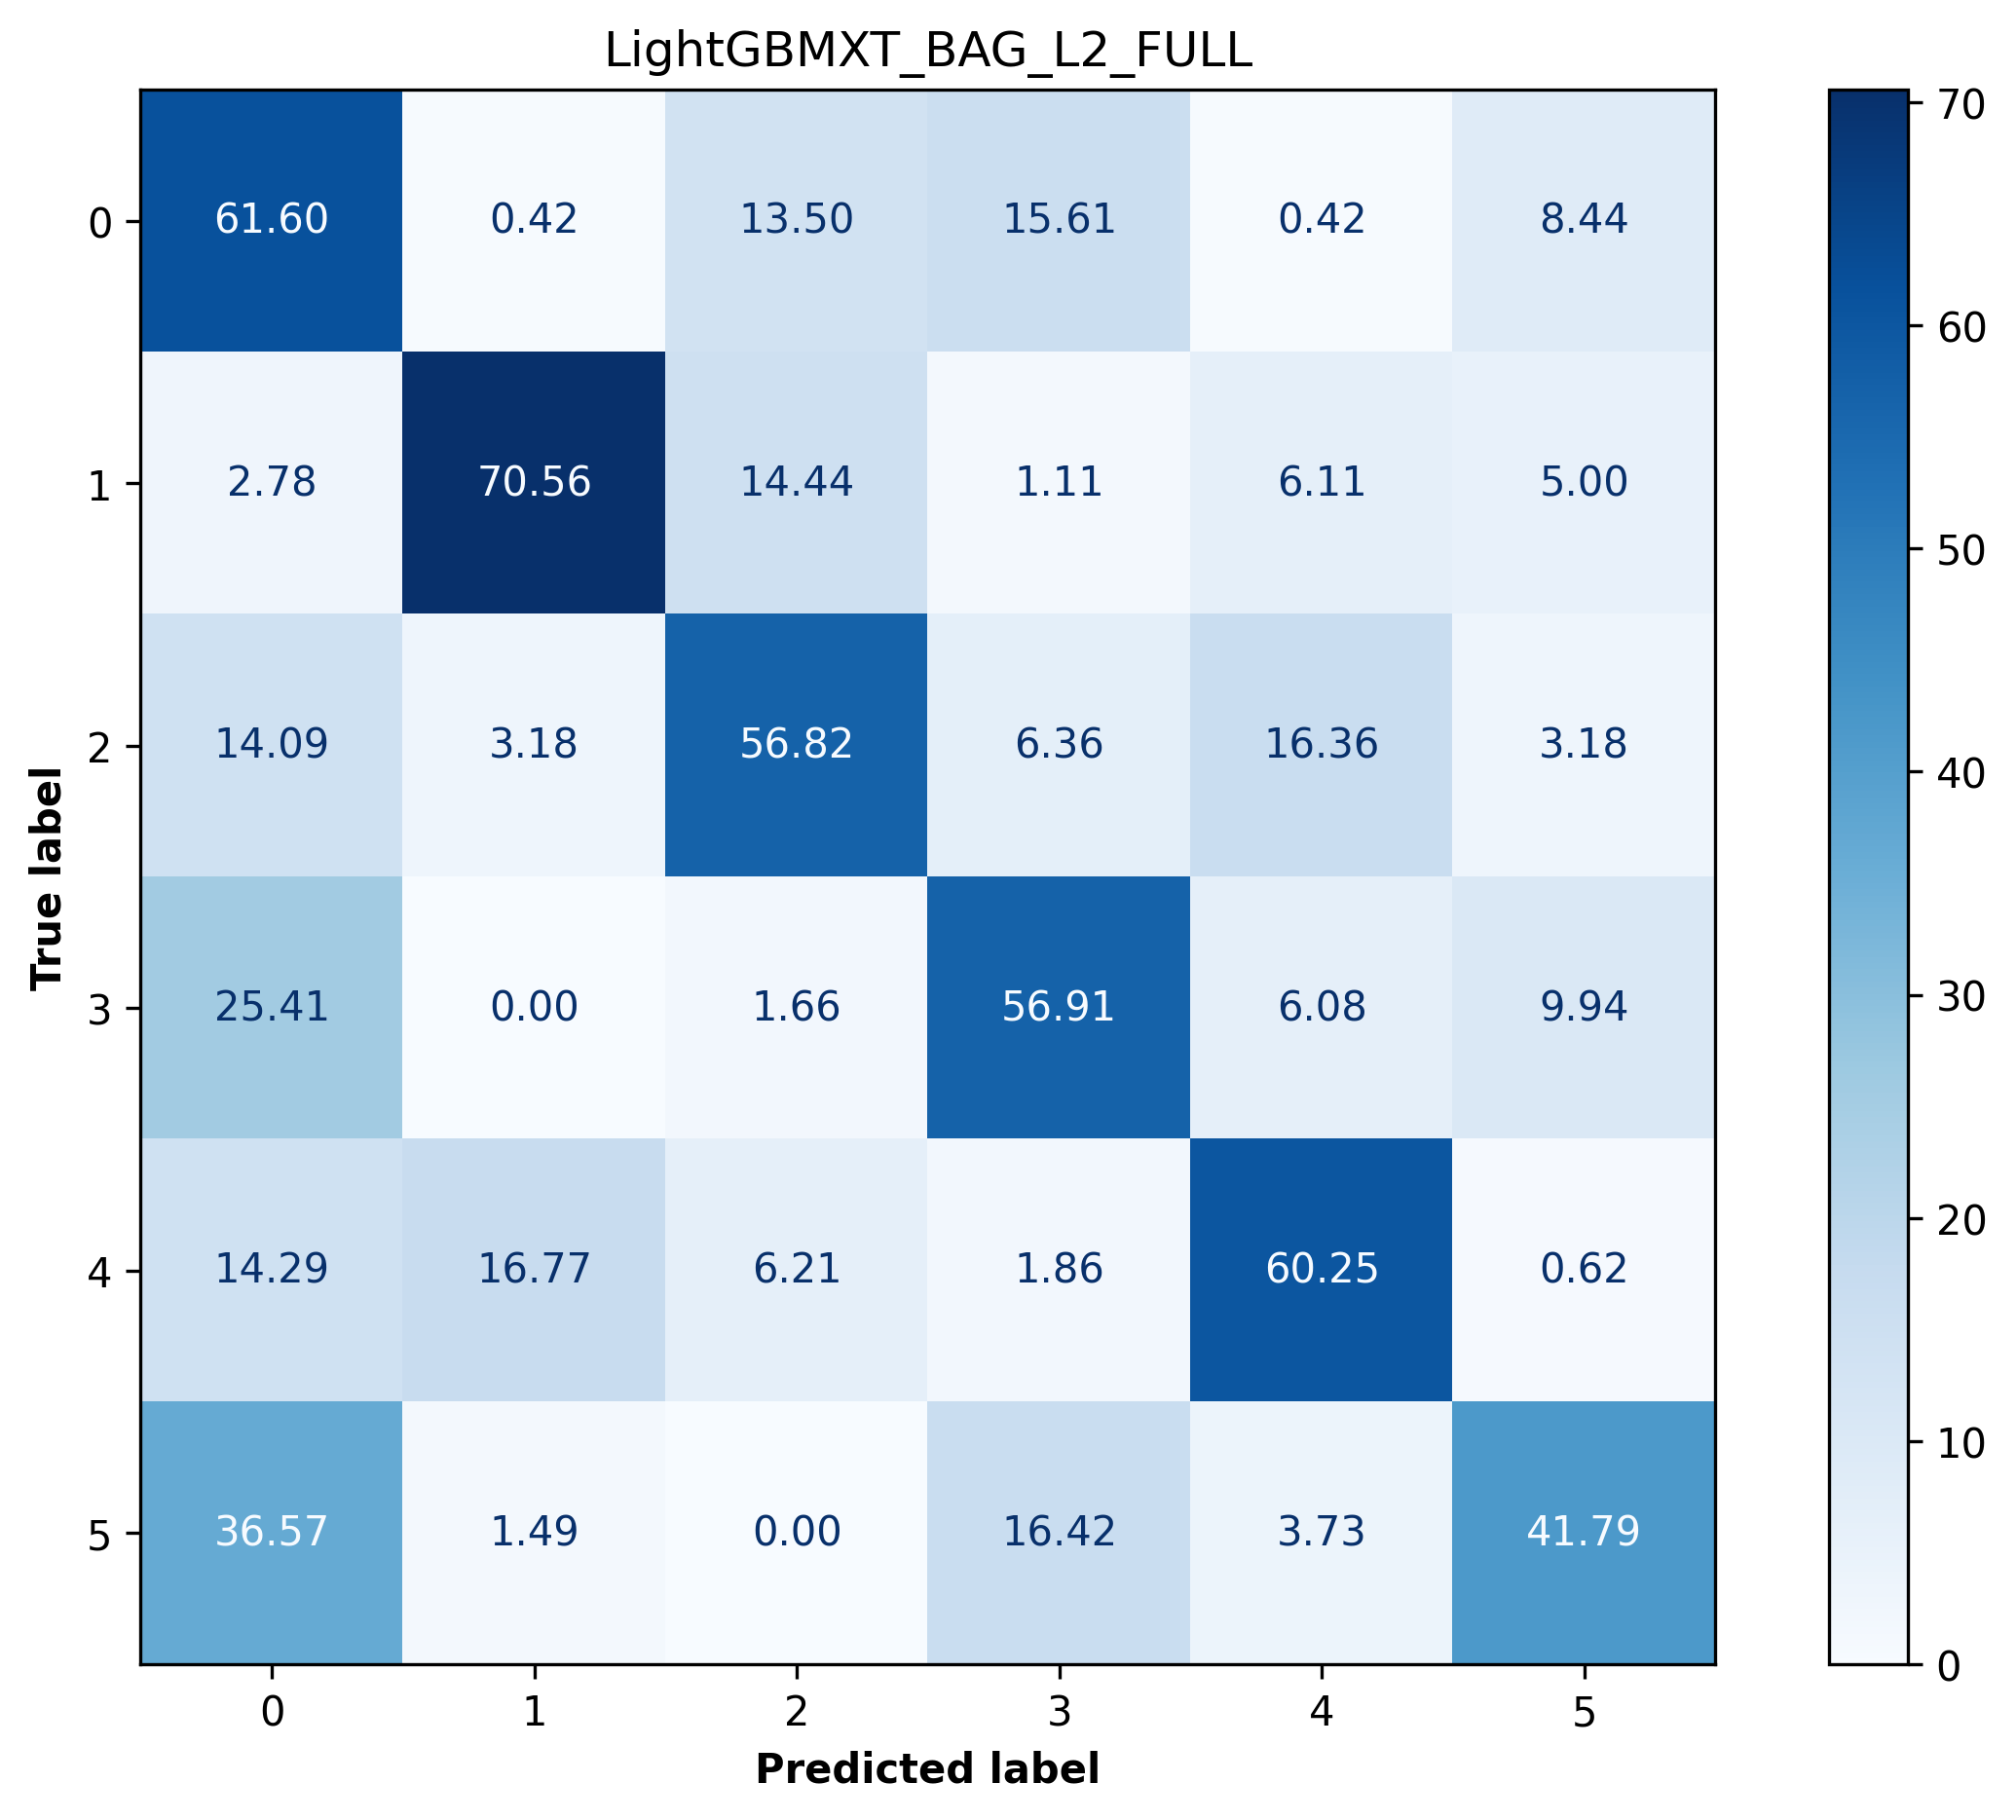

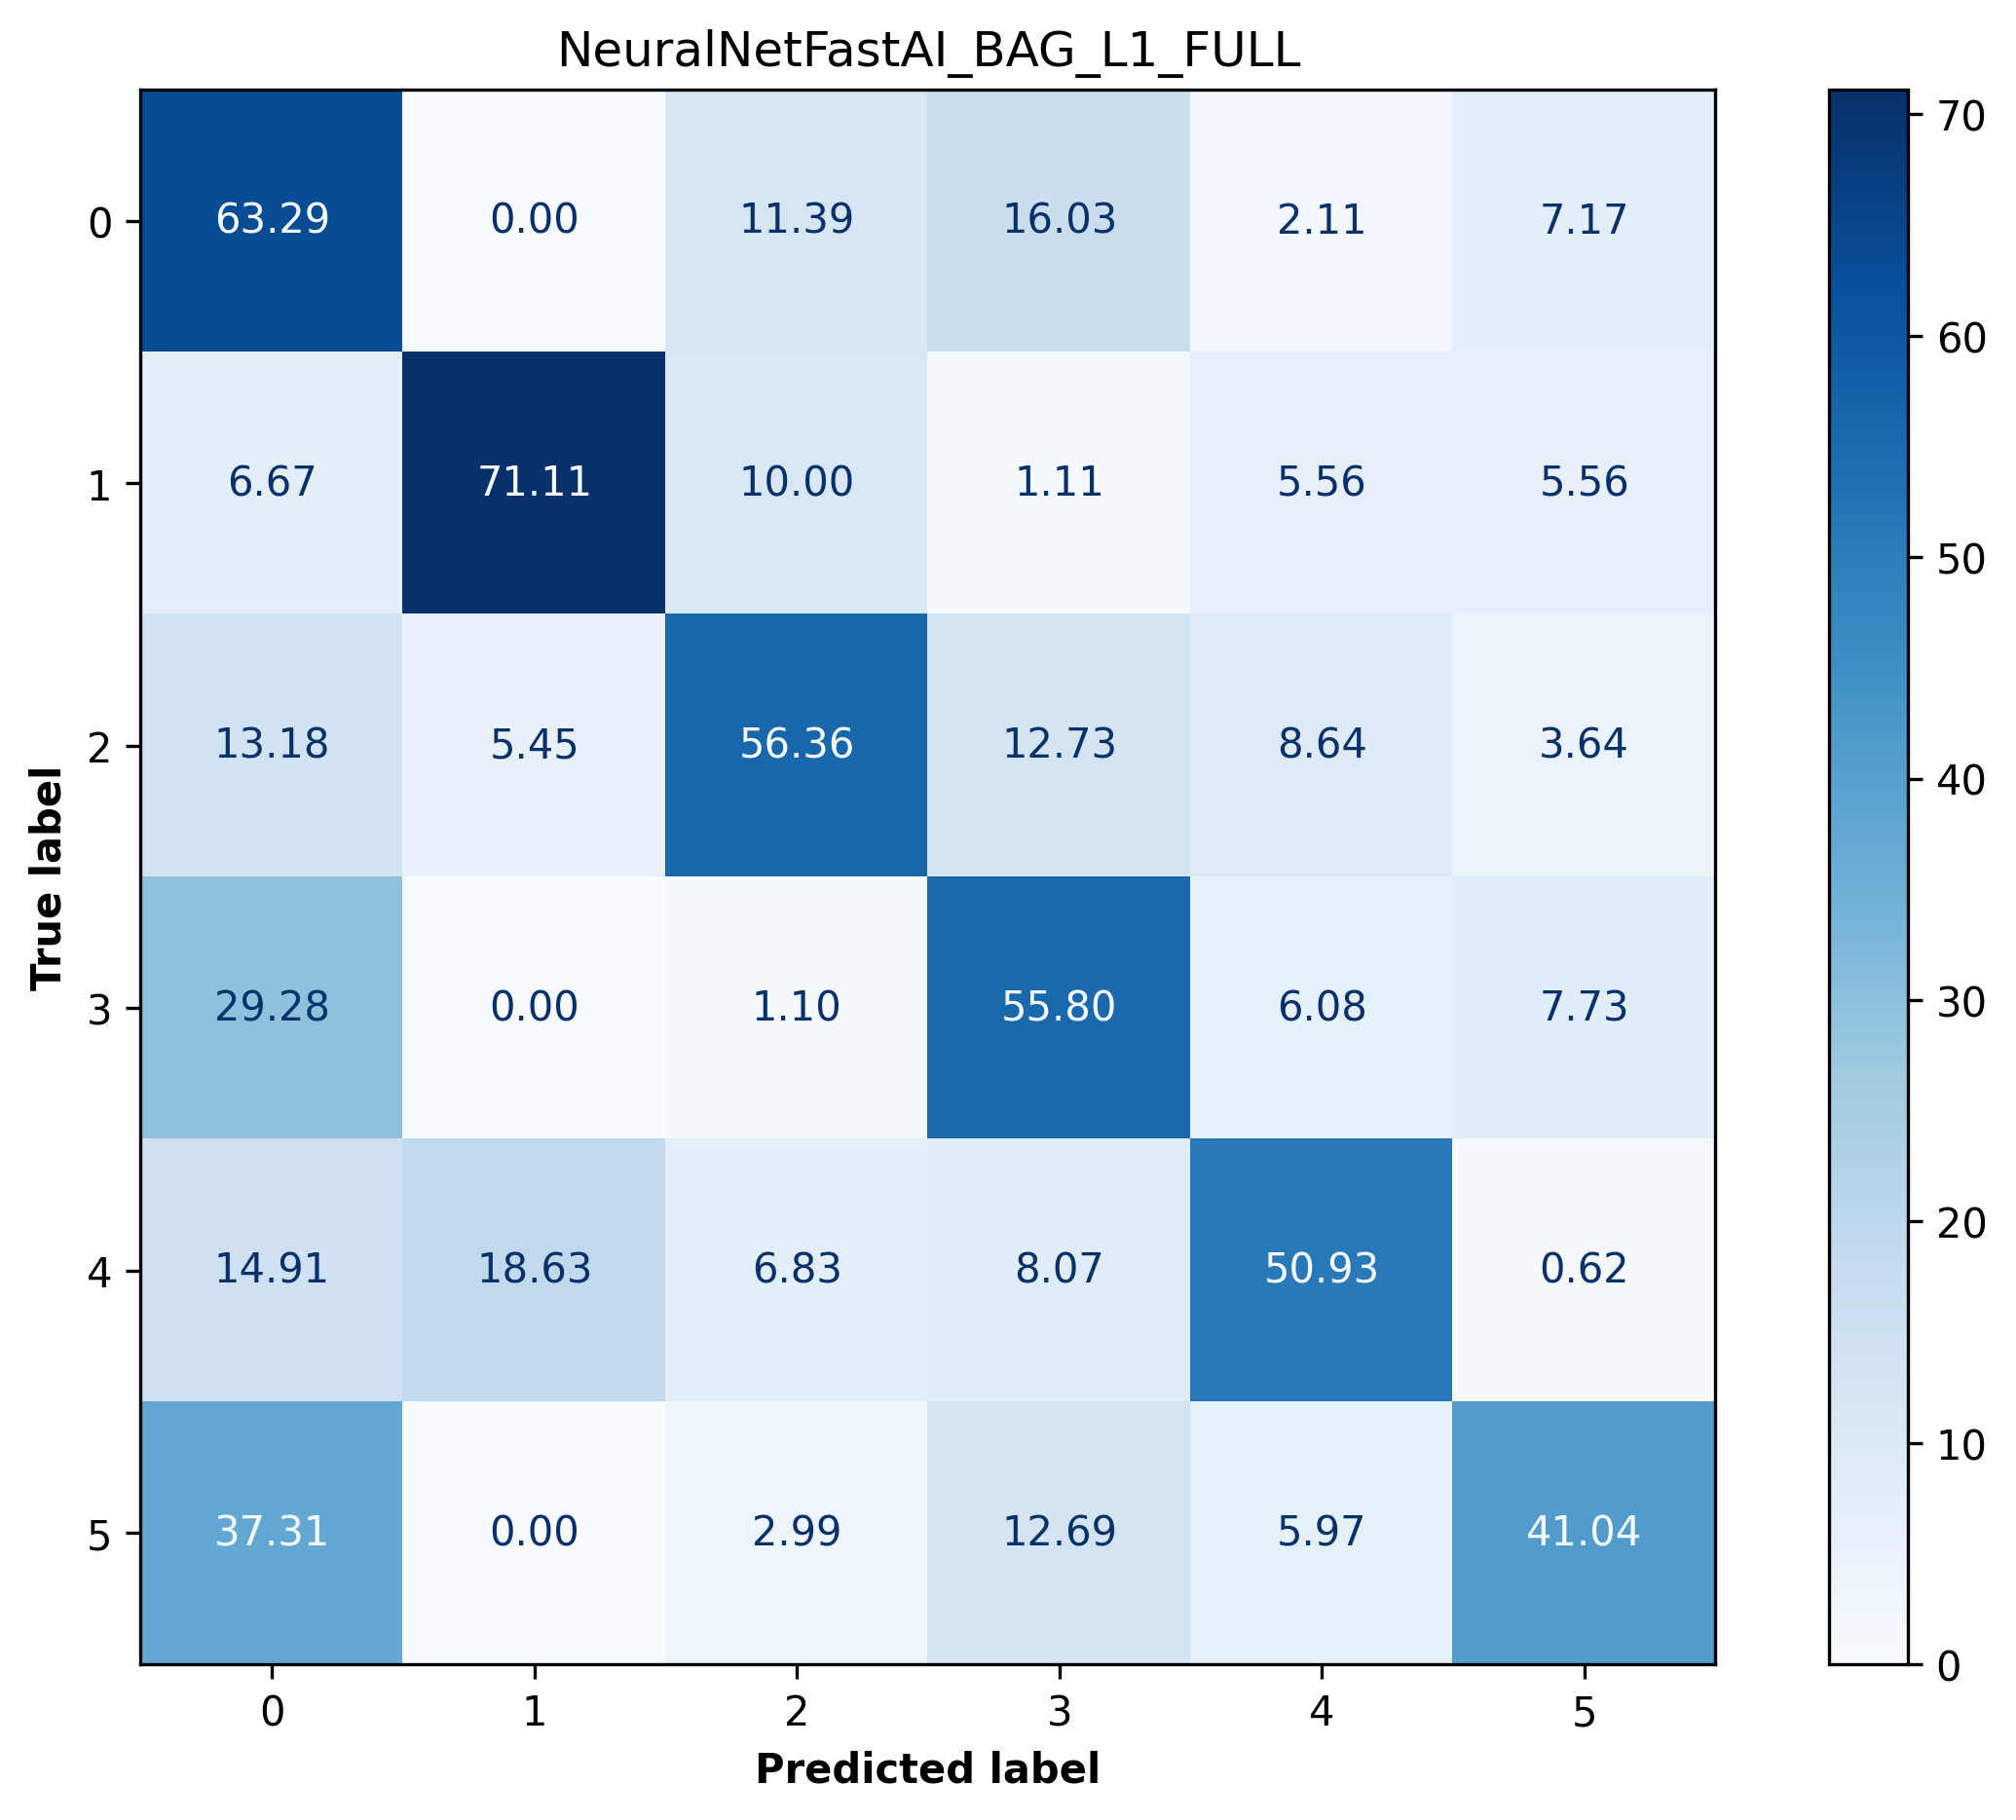

In [86]:
calculate_prediction_avg(joined_df_DINO.to_pandas() , ["Metadata_Plate", "Metadata_Well", "Metadata_Site"], predictor_DINO, ["LightGBMXT_BAG_L2_FULL", "NeuralNetFastAI_BAG_L1_FULL"], meta_dino)

In [ ]:
calculate_prediction_avg(test_data_CP_join, ["Metadata_Plate", "Metadata_Well", "Metadata_Site"], predictor_CP, ["LightGBMXT_BAG_L2", "NeuralNetFastAI_BAG_L1"], meta_feats_CP)

In [58]:
calculate_prediction_avg(joined_df_DP, ["Metadata_Plate", "Metadata_Well", "Metadata_Site"], predictor_DP, ["LightGBMXT_BAG_L2", "NeuralNetFastAI_BAG_L1"], meta_DP)